In [29]:
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx # Buat simpan model ke ONNX
from sklearn.preprocessing import MinMaxScaler # Buat scaling data
from sklearn import metrics # Buat evaluasi model
from sklearn.metrics import r2_score # R2 score
from datetime import datetime, timedelta # Buat atur tanggal
from keras.models import Sequential # Model Sequential Keras
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, BatchNormalization # Layer-layer model
from keras.metrics import RootMeanSquaredError as rmse # Metrik RMSE

# Cek versi TensorFlow (biar yakin)
print(f"TensorFlow Version: {tf.__version__}")
# Cek support GPU (penting buat training cepet)
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Inisialisasi MetaTrader5 (buat ambil data histori)
if not mt5.initialize():
    print(f"initialize() failed, error code = {mt5.last_error()}")
    quit()

# Tunjukin info terminal MT5
terminal_info = mt5.terminal_info()
print(f"MetaTrader5 Terminal Info: {terminal_info}")

# Tentukan path buat simpan model (ini bisa kamu sesuaikan)
# Contoh: simpan di folder MQL5 Files MetaTrader5
file_path = terminal_info.data_path + "\\MQL5\\Files\\"
print(f"Model save path: {file_path}")

TensorFlow Version: 2.10.0
GPU Available: True
MetaTrader5 Terminal Info: TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=True, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=4885, maxbars=100000, codepage=0, ping_last=16377, community_balance=0.0, retransmission=4.256041270703231, company='MetaQuotes Ltd.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
Model save path: C:\Users\User\AppData\Roaming\MetaQuotes\Terminal\D0E8209F77C8CF37AD8BF550E51FF075\MQL5\Files\


In [30]:
# Tentukan tanggal mulai dan akhir untuk data histori
end_date = datetime.now() # Ambil sampai tanggal hari ini
start_date = datetime(2020, 1, 1) # Mulai dari 1 Januari 2020

print(f"Data Start Date: {start_date}")
print(f"Data End Date: {end_date}")

# Ambil data harga XAUUSD (Timeframe H1) dari MT5
# time_step yang digunakan MT5.TIMEFRAME_H1 (1 jam)
xauusd_rates = mt5.copy_rates_range("XAUUSD", mt5.TIMEFRAME_H1, start_date, end_date)

# Bikin DataFrame dari data yang diambil
df = pd.DataFrame(xauusd_rates)
df['time'] = pd.to_datetime(df['time'], unit='s') # Ubah timestamp ke datetime
df = df.set_index('time') # Set kolom 'time' jadi index

# Cek beberapa baris awal dan akhir DataFrame
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Tail:")
print(df.tail())
print(f"\nDataFrame Shape: {df.shape}") # Liat berapa banyak data (rows, columns)

# Kita cuma butuh kolom 'close' untuk prediksi
data = df['close'].values.reshape(-1, 1) # Reshape biar jadi 2D array

Data Start Date: 2020-01-01 00:00:00
Data End Date: 2025-06-01 05:07:25.508774

DataFrame Head:
                open      high       low     close  tick_volume  spread  \
time                                                                      
2020-01-02  1518.594  1531.405  1517.302  1528.873        49576       0   
2020-01-03  1528.855  1553.549  1528.855  1552.013        66824       0   
2020-01-05  1576.486  1582.334  1566.985  1569.346         5740       0   
2020-01-06  1569.281  1580.096  1560.948  1563.836        72196       0   
2020-01-07  1563.853  1598.474  1555.407  1595.143        74863       0   

            real_volume  
time                     
2020-01-02            0  
2020-01-03            0  
2020-01-05            0  
2020-01-06            0  
2020-01-07            0  

DataFrame Tail:
                         open      high       low     close  tick_volume  \
time                                                                       
2025-05-30 16:00:00  3288.6

In [31]:
# Scaling data menggunakan MinMaxScaler (biar nilainya antara 0 dan 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tentukan ukuran data training (80%) dan testing (20%)
training_size = int(len(scaled_data) * 0.80)
train_data_initial = scaled_data[0:training_size, :]
test_data_initial = scaled_data[training_size:, :]

print(f"\nTraining data size: {len(train_data_initial)} samples")
print(f"Testing data size: {len(test_data_initial)} samples")

# --- Fungsi split_sequence (dari notebook sebelumnya, kita pake lagi) ---
# Fungsi ini ubah data deret waktu jadi pasangan input (X) dan output (y)
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Tentukan time_step (jumlah jam ke belakang yang dilihat model)
# Kita coba 240 jam (10 hari) sebagai awal untuk data 5 tahun
time_step = 120 # Ini yang baru, sebelumnya 120

# Split data training dan testing menjadi sampel input (X) dan output (y)
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

# Reshape input (X) agar sesuai format yang dibutuhkan LSTM: [samples, time steps, features]
# Features di sini 1 karena cuma kolom 'close'
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Training data size: 20377 samples
Testing data size: 5095 samples

x_train shape: (20257, 120, 1)
y_train shape: (20257, 1)
x_test shape: (4975, 120, 1)
y_test shape: (4975, 1)


In [32]:
import tensorflow as tf # Pastikan TensorFlow diimport
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, BatchNormalization
from keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.regularizers import l1_l2 # Import L1/L2 regularizer

In [33]:
# --- Model Architecture dengan L1/L2 Regularization ---
model = Sequential()

# --- Conv1D Block Pertama ---
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                 input_shape=(time_step, 1),
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))) # Tambahin L1/L2 di sini
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) # Kamu bisa coba naikin dropout rate juga, misal 0.3 atau 0.4

# --- Conv1D Block Kedua (Opsional) ---
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))) # L1/L2
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) # Sesuaikan dropout

# --- Bidirectional LSTM Block Pertama ---
model.add(Bidirectional(LSTM(units=100, return_sequences=True,
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), # L1/L2 di LSTM
                             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)))) # Regularizer buat recurrent state
model.add(BatchNormalization())
model.add(Dropout(0.4)) # Mungkin naikin dropout di sini

# --- Bidirectional LSTM Block Kedua (Opsional) ---
model.add(Bidirectional(LSTM(units=50, return_sequences=False,
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), # L1/L2 di LSTM
                             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)))) # Regularizer buat recurrent state
model.add(BatchNormalization())
model.add(Dropout(0.4)) # Sesuaikan dropout

# --- Output Layer ---
model.add(Dense(units=1, activation='sigmoid',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))) # L1/L2 di Dense output

# Compile model
# Kamu bisa coba learning rate yang lebih kecil juga di sini
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # Contoh LR lebih kecil
              loss='mse',
              metrics=[rmse()])

# Tunjukin ringkasan arsitektur model
print("\nModel Architecture Summary (dengan L1/L2 Regularization):")
model.summary()


Model Architecture Summary (dengan L1/L2 Regularization):
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 120, 64)           256       
                                                                 
 batch_normalization_16 (Bat  (None, 120, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 60, 64)           0         
 1D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 60, 64)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 60, 128)           24704     
                                                             

In [34]:
# --- Di bagian atas cell training, sebelum model.fit() ---
# Import callbacks yang kita butuhin
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Definisikan EarlyStopping callback
# Ini buat berhentiin training kalo val_loss udah gak membaik lagi
# biar gak buang-buang waktu dan dapetin model terbaik pas val_loss paling rendah
early_stopping = EarlyStopping(
    monitor='val_loss',      # Kita pantau 'val_loss' (loss di data validasi)
    patience=15,             # Jumlah epoch tanpa perbaikan sebelum training dihentikan (misalnya 15 epoch)
    verbose=1,               # Kasih tau kalo training dihentikan
    mode='min',              # Mode 'min' karena kita mau 'val_loss' sekecil mungkin
    restore_best_weights=True # Ini PENTING! Biar bobot modelnya balik ke kondisi terbaik pas 'val_loss' paling rendah
)

# 2. Definisikan ReduceLROnPlateau callback (Opsional tapi bagus buat dicoba)
# Ini buat ngurangin learning rate secara otomatis kalo 'val_loss' udah mentok
# Siapa tau learning rate kegedean, jadi bisa bantu modelnya "turun gunung" lebih alus ke loss minimal
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Pantau 'val_loss' juga
    factor=0.2,         # Learning rate bakal dikali 0.2 (misal dari 0.001 jadi 0.0002)
    patience=7,         # Jumlah epoch tanpa perbaikan sebelum learning rate dikurangi (misalnya 7 epoch)
    verbose=1,          # Kasih tau kalo learning rate dikurangi
    mode='min',         # Mode 'min' juga
    min_lr=1e-6         # Batas bawah learning rate biar gak kekecilan banget
)


In [35]:
import time

time_calc_start = time.time()

# Latih model
# Jumlah epochs dan batch_size ini bisa kamu tuning ya, bal!
# Dengan data 5 tahun, 300 epochs mungkin butuh waktu lama, bisa dimulai dengan 50-100 epochs dulu
history = model.fit(
    x_train,
    y_train,
    epochs=100, # Maksimum epoch yang kita set (misalnya 100 dari blueprint)
    batch_size=64, # Batch size yang kita set
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[early_stopping, reduce_lr] # Nah, ini dia! Kita masukin callback-nya di sini
)

fit_time_seconds = time.time() - time_calc_start
print(f"\nFit time: {fit_time_seconds:.2f} seconds.")

Epoch 1/100
317/317 [==============================] - 10s 21ms/step - loss: 0.2852 - root_mean_squared_error: 0.2310 - val_loss: 0.3885 - val_root_mean_squared_error: 0.4479 - lr: 5.0000e-04
Epoch 2/100
317/317 [==============================] - 6s 18ms/step - loss: 0.1849 - root_mean_squared_error: 0.1693 - val_loss: 0.1374 - val_root_mean_squared_error: 0.0859 - lr: 5.0000e-04
Epoch 3/100
317/317 [==============================] - 6s 19ms/step - loss: 0.1220 - root_mean_squared_error: 0.1100 - val_loss: 0.1424 - val_root_mean_squared_error: 0.2247 - lr: 5.0000e-04
Epoch 4/100
317/317 [==============================] - 10s 31ms/step - loss: 0.0845 - root_mean_squared_error: 0.0827 - val_loss: 0.1398 - val_root_mean_squared_error: 0.2745 - lr: 5.0000e-04
Epoch 5/100
317/317 [==============================] - 11s 36ms/step - loss: 0.0572 - root_mean_squared_error: 0.0548 - val_loss: 0.1040 - val_root_mean_squared_error: 0.2431 - lr: 5.0000e-04
Epoch 6/100
317/317 [=====================


Training History Keys: dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])


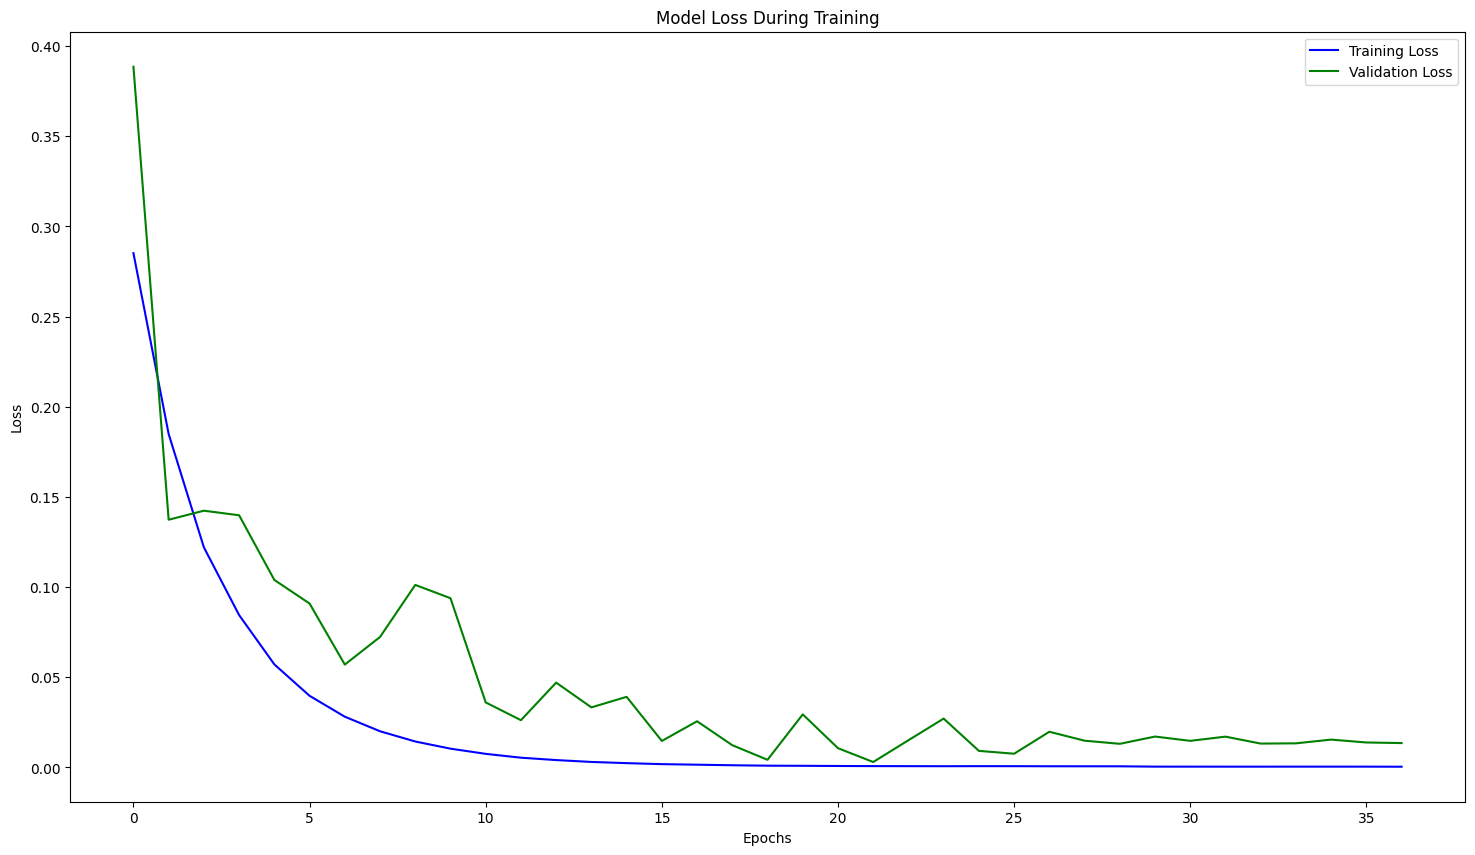

78/78 [==============================] - 1s 9ms/step - loss: 0.0030 - root_mean_squared_error: 0.0511

Training Loss: 0.0006, Training RMSE: 0.0144
Testing Loss: 0.0030, Testing RMSE: 0.0511
156/156 [==============================] - 1s 6ms/step

Training R2 Score: 0.9725
Testing R2 Score: 0.8560


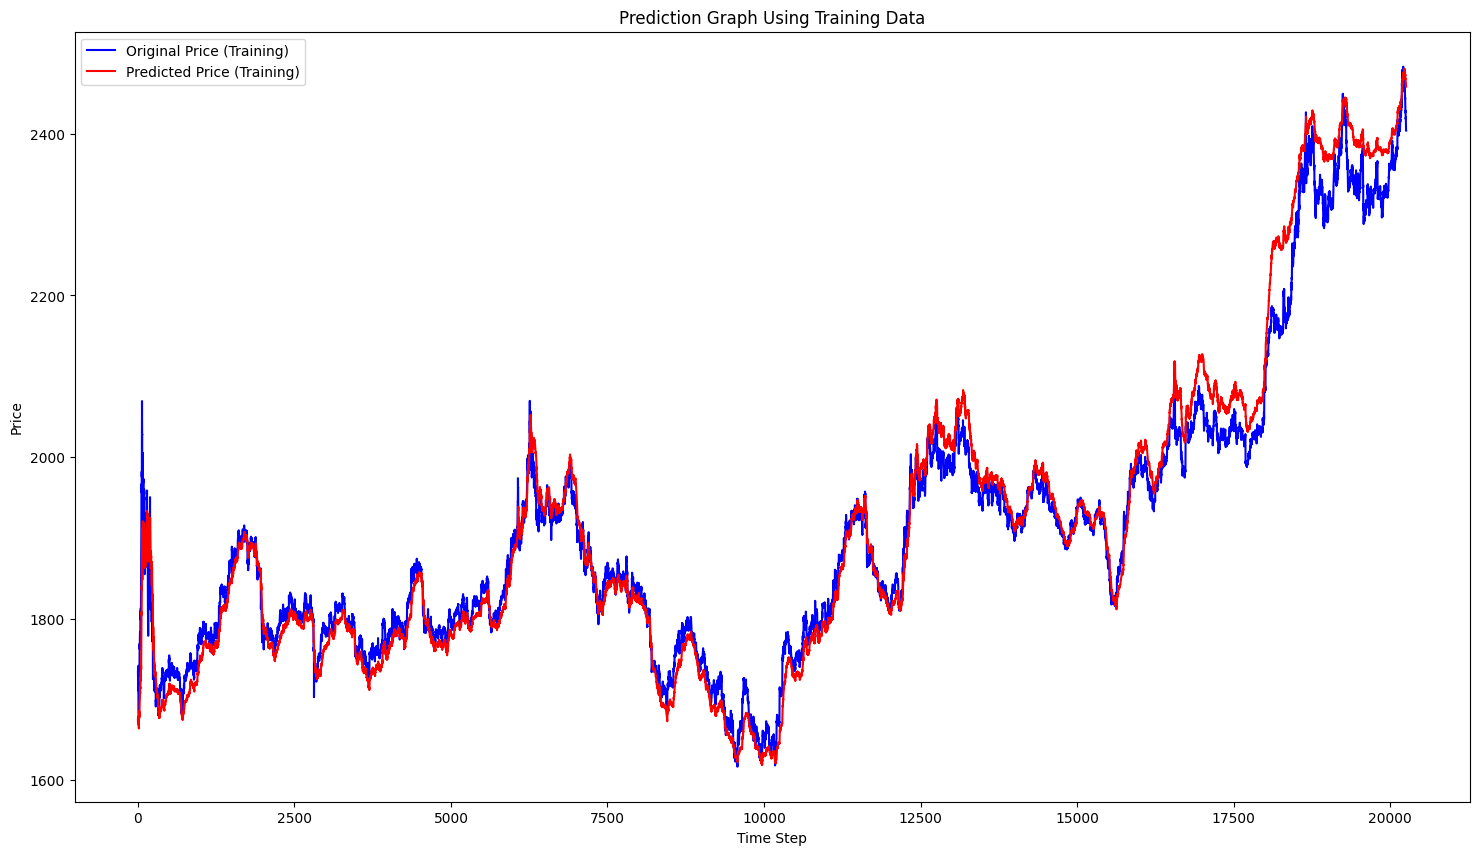

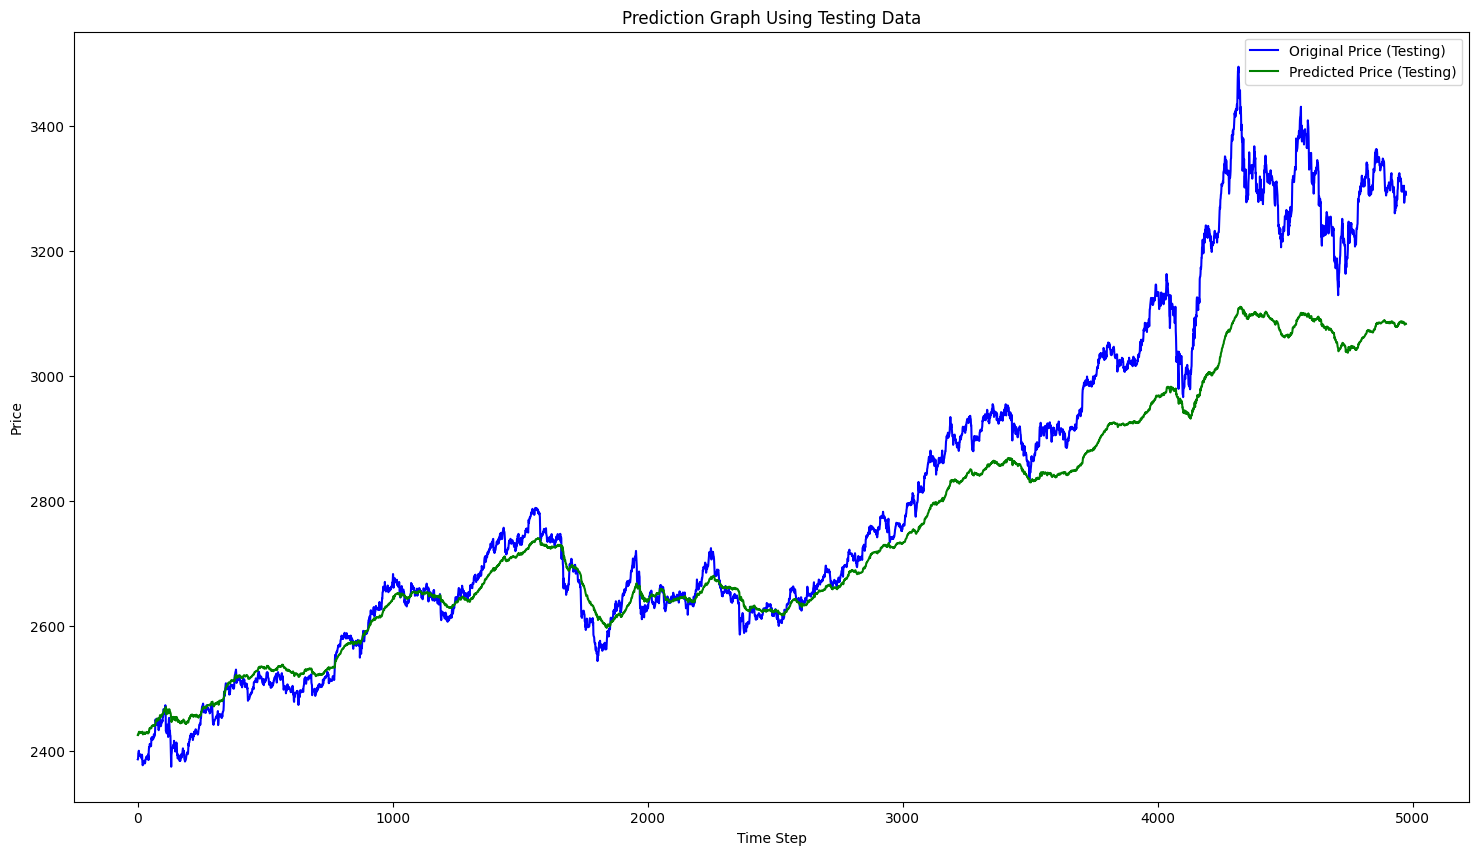

In [36]:
# Liat keys dari history training
print(f"\nTraining History Keys: {history.history.keys()}")

# Plot grafik Loss (Training vs Validation)
plt.figure(figsize=(18, 10))
plt.plot(history.history['loss'], label='Training Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='g')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss During Training")
plt.legend()
plt.show()

# Evaluasi model pada data training dan testing
train_loss, train_rmse = model.evaluate(x_train, y_train, batch_size=64)
test_loss, test_rmse = model.evaluate(x_test, y_test, batch_size=64)

print(f"\nTraining Loss: {train_loss:.4f}, Training RMSE: {train_rmse:.4f}")
print(f"Testing Loss: {test_loss:.4f}, Testing RMSE: {test_rmse:.4f}")

# Bikin prediksi pakai data training dan testing
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Ubah prediksi dan data asli ke skala harga sebenarnya (inverse_transform)
plot_y_train = y_train.reshape(-1, 1)
plot_y_test = y_test.reshape(-1, 1)

train_predict_actual = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(plot_y_train)
test_predict_actual = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(plot_y_test)

# Hitung metrik R2 score
r2_train = r2_score(y_train_actual, train_predict_actual)
r2_test = r2_score(y_test_actual, test_predict_actual)

print(f"\nTraining R2 Score: {r2_train:.4f}")
print(f"Testing R2 Score: {r2_test:.4f}")

# --- Visualisasi Prediksi vs Aktual (Training Data) ---
plt.figure(figsize=(18, 10))
plt.plot(y_train_actual, color='b', label='Original Price (Training)')
plt.plot(train_predict_actual, color='red', label='Predicted Price (Training)')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

# --- Visualisasi Prediksi vs Aktual (Testing Data) ---
plt.figure(figsize=(18, 10))
plt.plot(y_test_actual, color='b', label='Original Price (Testing)')
plt.plot(test_predict_actual, color='g', label='Predicted Price (Testing)')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

In [37]:
# # Simpan model ke format ONNX
# # Ini penting biar model bisa gampang di-deploy ke berbagai platform, termasuk mungkin MT5!
# onnx_output_path = "model.xauusd.H1.5years_ConvBiLSTM_v2.onnx"
# onnx_model = tf2onnx.convert.from_keras(model, output_path=onnx_output_path)
# print(f"\nModel saved to: {onnx_output_path}")

# # Matikan koneksi MetaTrader5
# mt5.shutdown()
# print("MetaTrader5 connection shut down.")